In [1]:
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split,RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.cluster import KMeans



## Disclaimer
<font size='3'>before loading the data I extracted the zip files that contain the data.</font>

<font size='3'>the train data should be in the same directory as this notebook and in the `train` folder</font>

In [2]:
modelDir = './models'

if not os.path.exists(modelDir):
    os.makedirs(modelDir)
    
def save_model (model, file_name):
    if model:
        model_file_name = f"{file_name}_cats_v_dogs.sav"
        joblib.dump(model, os.path.join(modelDir,model_file_name))

def load_model (file_name):
    model_file_name = f"{file_name}_cats_v_dogs.sav"
    try:
        return joblib.load(os.path.join(modelDir,model_file_name))
    except:
        return None

# Processing colorful images
<font size="4">In this section I will try to process the images with colors but a resized version of each images.</font>

In [3]:
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [4]:
data = []
label = []
path = "./train/"
IMG_SIZE = 32

for file in os.listdir(path):
    img=cv2.imread(path+file)
    file_label = file.split('.')[0]
    
    if file_label == 'cat':
        label.append(1)
    else:
        label.append(0)
    data.append(img)

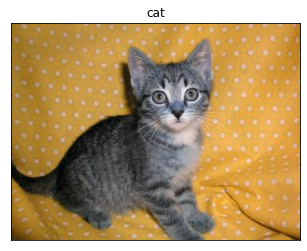

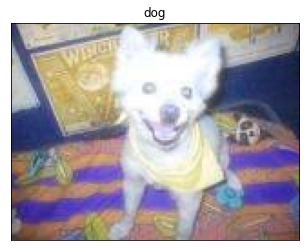

In [5]:
display_one(data[1],"cat" if label[1]==1 else "dog")
display_one(data[2],"cat" if label[2]==1 else "dog")

## The reason why I loop over the data like this is because the images aren't flat and I don't want to have issues with objects

In [6]:
flattenedData = []
for i in range(len(data)):
    img=cv2.resize(data[i],(IMG_SIZE,IMG_SIZE),interpolation=cv2.INTER_AREA)
    img=img.astype('float32')
    img = img.ravel()
    flattenedData.append(img)

flattenedData = np.array(flattenedData)   

In [7]:
len(flattenedData[1])

3072

In [8]:
x_train, x_test, y_train, y_test = train_test_split(flattenedData,label , test_size=0.1 ,random_state=21)


## Should I normalize or standardize before PCA?

Yes, it is necessary to normalize data before performing PCA. The PCA calculates a new projection of your data set.

In [9]:
scaling_pipeline = Pipeline(
    [
        ('std_scaler', StandardScaler()),
        ('pca',PCA(n_components=0.90, random_state=0,svd_solver='auto')),       
    ]
)

x_train_scaled = scaling_pipeline.fit_transform(x_train)
x_test_scaled = scaling_pipeline.transform(x_test)


125


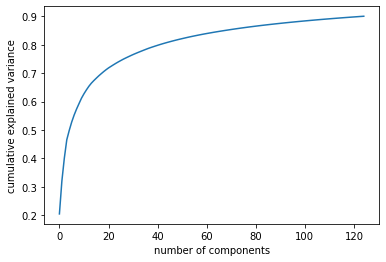

In [10]:
pca_data = scaling_pipeline['pca']

plt.plot(np.cumsum(pca_data.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
print(pca_data.n_components_)

In [32]:
scaling_kmeans_pipeline = Pipeline(
    [
        ('std_scaler', StandardScaler()),
        ("kmeans", KMeans(n_clusters=30)),
    ]
)

x_train_scaled_kmeans = scaling_kmeans_pipeline.fit_transform(x_train)
x_test_scaled_kmeans = scaling_kmeans_pipeline.transform(x_test)

---------------

## KNN

In [11]:
knn_cls = KNeighborsClassifier()
knn_cls.fit(x_train_scaled,y_train)
knn_cls.score(x_test_scaled,y_test)

0.6048

In [12]:
knn_param_grid =     {
     'n_neighbors': list(range(3,100,10)),
     'weights':['uniform','distance'],
     'metric': ['euclidean','manhattan','minkowski'],
    }

knn_grid_search = RandomizedSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    knn_param_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=True,
    random_state=0,
    n_iter=15
)
knn_grid_search.fit(x_train_scaled,y_train)

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=-1), n_iter=15,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'minkowski'],
                                        'n_neighbors': [3, 13, 23, 33, 43, 53,
                                                        63, 73, 83, 93],
                                        'weights': ['uniform', 'distance']},
                   random_state=0, return_train_score=True, scoring='accuracy')

In [13]:
knn_grid_search.best_estimator_

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=53,
                     weights='distance')

In [14]:
knn_grid_search.best_score_

0.6130222222222222

## RandomForest

In [15]:
forest_clf = RandomForestClassifier(random_state=0,n_estimators=200, n_jobs=-1)


forest_clf.fit(x_train_scaled,y_train)
forest_clf.score(x_test_scaled,y_test)


0.6472

In [16]:
forest_params = {
     'n_estimators': [100,200,400],
     'max_depth':[None,30,100],
     'max_features': ['auto','sqrt','log2'],
     'random_state':[0]
}

In [17]:
forest_grid_search = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=-1),
    forest_params,
    cv=3,
    scoring='accuracy',
    return_train_score=True,
    random_state=0
)

forest_grid_search.fit(x_train_scaled,y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [None, 30, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 200, 400],
                                        'random_state': [0]},
                   random_state=0, return_train_score=True, scoring='accuracy')

In [18]:
forest_grid_search.best_estimator_.score(x_test_scaled,y_test)

0.6484

### Trying the data that went through the kmeans pipeline

In [33]:
forest_grid_search = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=-1),
    forest_params,
    cv=3,
    scoring='accuracy',
    return_train_score=True,
    random_state=0
)

forest_grid_search.fit(x_train_scaled_kmeans,y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [None, 30, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 200, 400],
                                        'random_state': [0]},
                   random_state=0, return_train_score=True, scoring='accuracy')

In [34]:
forest_grid_search.best_estimator_.score(x_test_scaled_kmeans,y_test)

0.5816

## XGBoost

In [19]:

xgb_clf = XGBClassifier(n_jobs=-1, max_depth=6,gamma = 0,colsample_bytree = 0.8)

xgb_clf.fit(x_train_scaled,y_train)
xgb_clf.score(x_test_scaled,y_test)

0.6528

In [21]:
tuned_xgb = load_model("colorful_tuned_xgb")

if not tuned_xgb:
    print("no pretrained model found")
    xgb_params = {
        'max_depth': [3,6,10],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 500, 1000,2000],
        'colsample_bytree': [0.3, 0.7]
    }


    XGBGridsearch = RandomizedSearchCV(XGBClassifier(), xgb_params,scoring='accuracy',cv=3, random_state=0,n_jobs=-1)
    XGBGridsearch.fit(x_train_scaled,y_train)
    tuned_xgb = XGBGridsearch.best_estimator_
    save_model(tuned_xgb,"colorful_tuned_xgb")
else:
    print("loaded pre-trained model")
    tuned_xgb.score(x_test_scaled,y_test)






no pretrained model found


In [22]:
tuned_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
tuned_xgb.score(x_test_scaled,y_test)

0.6844

## Stacking

In [24]:
stacking_clf = StackingClassifier(estimators=[
    ('knn', knn_grid_search.best_estimator_),
    ('rf', forest_grid_search.best_estimator_)], final_estimator=XGBGridsearch.best_estimator_)

stacking_clf.fit(x_train_scaled,y_train)

stacking_clf.score(x_test_scaled,y_test)

0.6124

## Bagging

In [25]:
bagging = load_model("colorful_bagging")

if not bagging:
    bagging = BaggingClassifier(base_estimator=XGBGridsearch.best_estimator_,n_estimators=10, random_state=0,n_jobs=-1)
    bagging.fit(x_train_scaled,y_train)
    save_model(bagging,"colorful_bagging")

else:
    print("loaded pre-trained model")
    print(bagging.score(x_test_scaled,y_test))
    




loaded pre-trained model
0.6856


In [26]:
bagging.score(x_test_scaled,y_test)

0.6856

In [27]:
best_bagging = load_model("colorful_tuned_bagging")

if not best_bagging:
    print("no pretrained model found")
    bagging_params = {
        'n_estimators': [10, 50,100],
    }

    bagging_grid = GridSearchCV(bagging, bagging_params,scoring='accuracy',cv=3)
    bagging_grid.fit(x_train_scaled,y_train)
    best_bagging = bagging_grid.best_estimator_
    save_model(bagging_grid.best_estimator_,"colorful_tuned_bagging")
else:
    print("loaded pre-trained model")
    best_bagging.score(x_test_scaled,y_test)




loaded pre-trained model


In [28]:
best_bagging.score(x_test_scaled,y_test)

0.6872

------------

# Processing images in black and white

<font size='4'>in this section I have decided to take the models that performed the best without the tunning so that I can check if I can acheive better results but in black and white.<font>

In [ ]:
data_bw = []
for i in range(len(data)):
    img=cv2.cvtColor(data[i], cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img,(IMG_SIZE,IMG_SIZE),interpolation=cv2.INTER_AREA)
    img=img.astype('float32')
    img = img.ravel()
    data_bw.append(img)

data_bw = np.array(data_bw) 

In [ ]:
len(label)

In [ ]:
x_train_bw, x_test_bw, y_train_bw, y_test_bw = train_test_split(data_bw,label , test_size=0.1 ,random_state=21)


In [ ]:
x_train_bw_scaled = scaling_pipeline.fit_transform(x_train_bw)
x_test_bw_scaled = scaling_pipeline.transform(x_test_bw)


In [ ]:
xgb_clf = XGBClassifier(n_jobs=-1, max_depth=6,gamma = 0,colsample_bytree = 0.8)

xgb_clf.fit(x_train_bw_scaled,y_train)
xgb_clf.score(x_test_bw_scaled,y_test)

In [ ]:
forest_clf = RandomForestClassifier(random_state=0,n_estimators=200, n_jobs=-1)

forest_clf.fit(x_train_scaled,y_train)
forest_clf.score(x_test_scaled,y_test)

In [ ]:
forest_grid_search = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=-1),
    forest_params,
    cv=3,
    scoring='accuracy',
    return_train_score=True,
    random_state=0
)

forest_grid_search.fit(x_train_scaled,y_train)

In [ ]:
forest_grid_search.best_score_

In [ ]:
forest_grid_search.best_estimator_.score(x_test_scaled,y_test)